In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
import napari
import itk

from pathlib import Path
import time

%matplotlib inline

# Test of the lung navigation problem
In this notebook, we want to present iterative solutions of the lung navigation problem using harmonic navigation functions.
We decompose the study in 3 parts : 
- the solution of the heat equation at rest
- the Poisson equation with Dirichlet boundary condition (bc)
- the Poisson equation with the source beeing a bc  

Let's first define the numerical scheme for estimating the Laplace equation

## Finite difference laplacian with Dirichlet boundary conditions 

In [2]:
def create_laplacian_matrix_2d(
    nx: int, ny: int, dx: float, dy: float
) -> sp.lil_array:
    Dxx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Dyy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(ny, ny)) / dy**2
    return sp.kronsum(Dyy, Dxx, format="csr")

def create_laplacian_matrix_3d(
    nx: int, ny: int, nz: int, dx: float, dy: float, dz: float
) -> sp.lil_array:
    # Compute the 2D laplacian matrix
    laplace_2d = create_laplacian_matrix_2d(nx, ny, dx, dy)

    Dzz = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nz, nz)) / dz**2
    return sp.kronsum(Dzz, laplace_2d, format="csr")

In [3]:
# Definition of functions to convert between indices and subscripts
def ind2sub_2D(array_shape, ind):
    rows = (ind / array_shape[1])
    cols = ind % array_shape[1]
    return np.array([rows, cols], dtype='int')

def sub2ind_2D(array_shape, rows, cols):
    return int(rows*array_shape[1] + cols)

def ind2sub_3D(array_shape, ind):
    rows = (ind / (array_shape[1]*array_shape[2]))
    cols = (ind / array_shape[2]) % array_shape[1]
    slices = ind % array_shape[2]
    return np.array([rows, cols, slices], dtype='int')

def sub2ind_3D(array_shape, rows, cols, slices):
    return int(rows*array_shape[1]*array_shape[2] + cols*array_shape[2] + slices)

[Text(0.5, 1.0, '3D Laplacian matrix')]

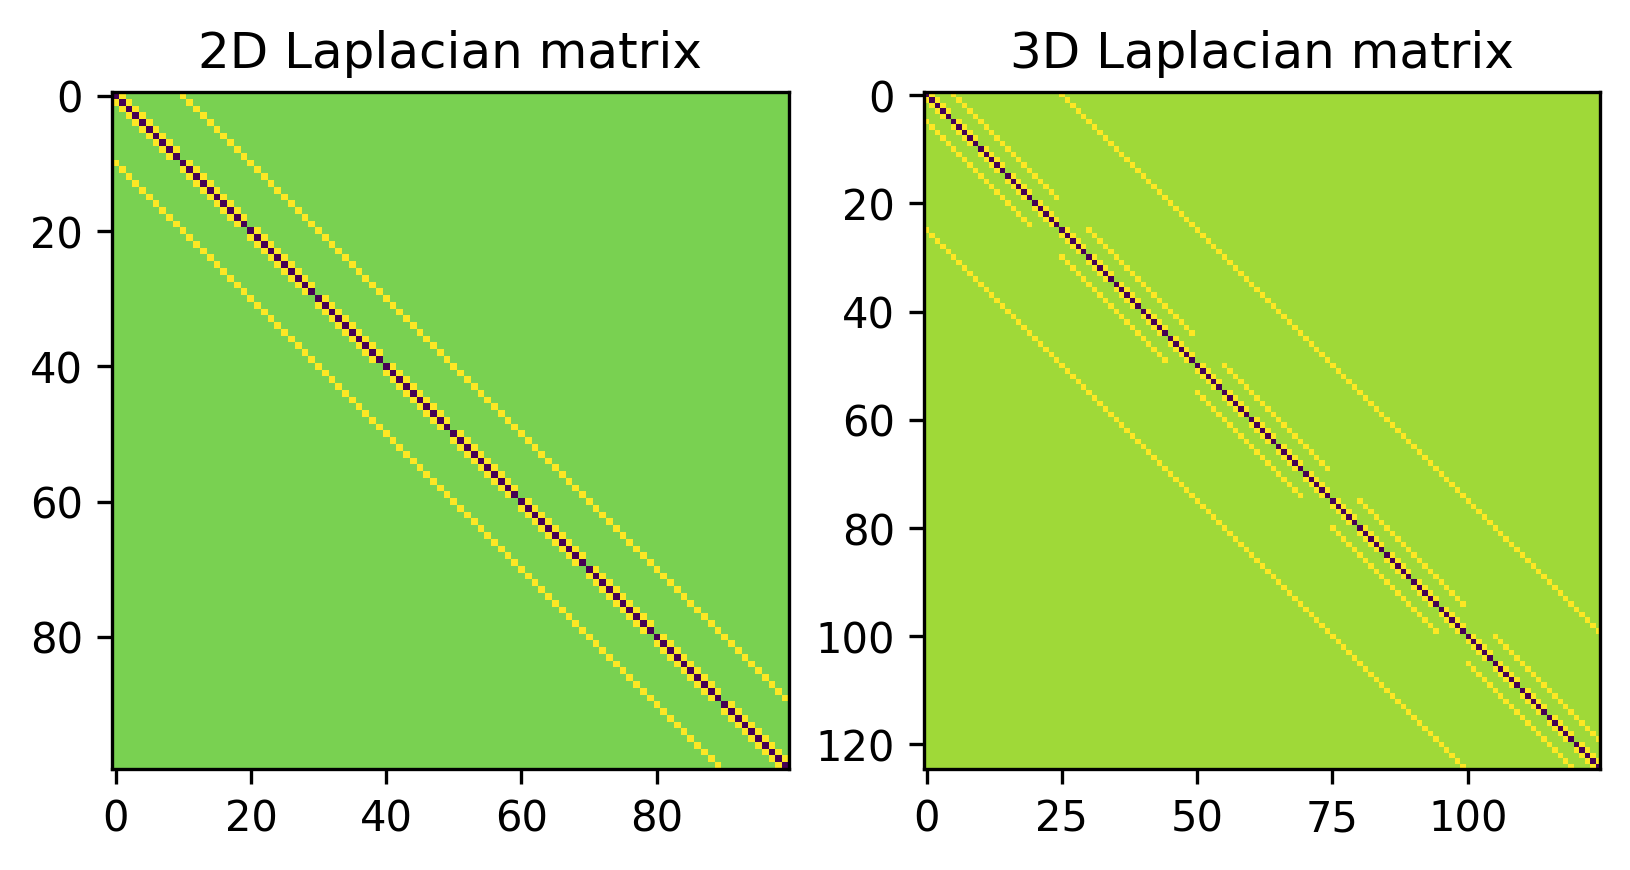

In [4]:
# Exemple of 2D and 3D laplacian matrix
laplacian2D = create_laplacian_matrix_2d(10, 10, 1, 1)
laplacian3D = create_laplacian_matrix_3d(5, 5, 5, 1, 1, 1)
fig, ax = plt.subplots(1, 2, dpi=300)
ax[0].imshow(laplacian2D.toarray())
ax[0].set(title="2D Laplacian matrix")
ax[1].imshow(laplacian3D.toarray())
ax[1].set(title="3D Laplacian matrix")

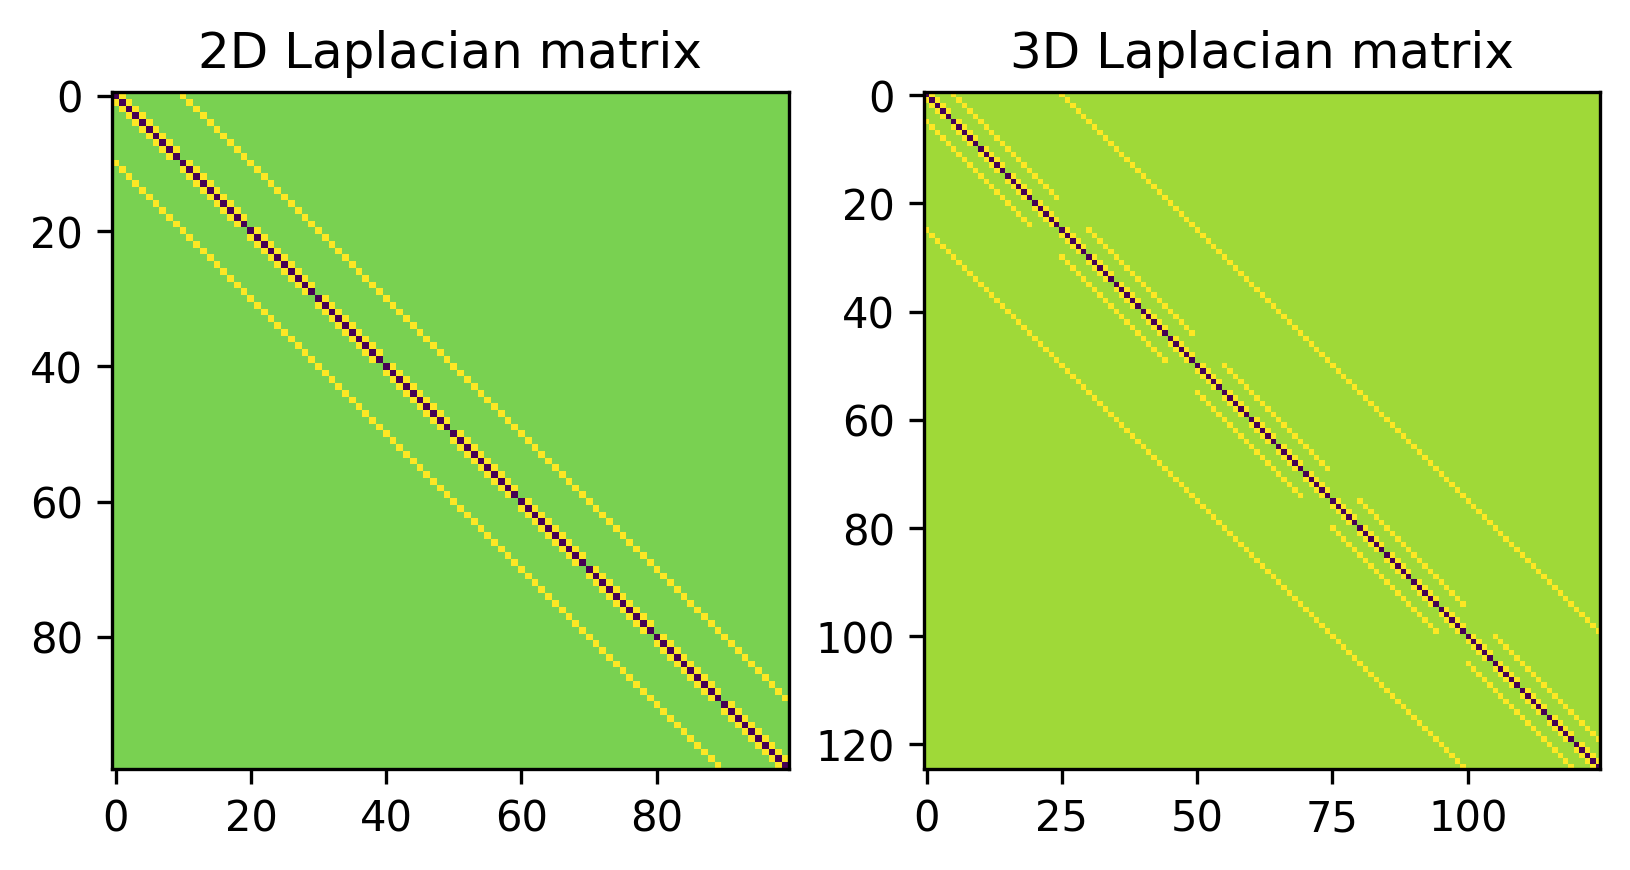

In [5]:
# Comparision with the laplacian matrix from scipy.ndimage
laplacian2D_sp = splinalg.LaplacianNd((10, 10), boundary_conditions='dirichlet')
laplacian3D_sp = splinalg.LaplacianNd((5, 5, 5), boundary_conditions='dirichlet')
fig, ax = plt.subplots(1, 2, dpi=300)
ax[0].imshow(laplacian2D_sp.toarray())
ax[0].set(title="2D Laplacian matrix")
ax[1].imshow(laplacian3D_sp.toarray())
ax[1].set(title="3D Laplacian matrix")

assert  np.array_equal(laplacian2D.toarray(), laplacian2D_sp.toarray())
assert  np.array_equal(laplacian3D.toarray(), laplacian3D_sp.toarray())

# Transformation of the labels in a discretized domain
Now that we have our matrix representation of the laplacian, we need to adapt it to the sparse domain represented by the label mask of the lung. For doing so, we first need to import the geometry and reduce the dimension of the computing domain  

In [6]:
# Read the label mask of the lung with its spacing informations
label_path = (
    Path('.').resolve()
    .joinpath("sample_datas", "label.nii.gz")
    .resolve(strict=True)
)
itk_label = itk.imread(label_path)

steps = itk_label["spacing"]
label_view = itk.array_view_from_image(itk_label)
# We keep only the points inside the bounding-box of the label mask + some margin
margin = 1 # number of pixels to add around the bounding-box
label = label_view[ndi.find_objects(ndi.binary_dilation(label_view, iterations=margin))[0]]
# label = label_view[ndi.find_objects(label_view)[0]]

res = label.shape
print(f"Resolution: {res}, Steps: {steps}")

viewer = None

Resolution: (462, 139, 235), Steps: [0.5       0.8203125 0.8203125]


If we need to view the geometry first and its superposition with the medical image, we can run the following script

In [ ]:
# Read the image of the lung with its spacing informations
image_path = (
    Path('.')
    .joinpath("sample_datas", "image.nii.gz")
    .resolve(strict=True)
)
itk_image = itk.imread(image_path)
image_view = itk.array_view_from_image(itk_image)

# view the image and its superposition with the labels in napari
viewer = napari.view_image(image_view, name="image", scale=steps)
viewer.add_image(label_view, name="label", opacity=0.5, scale = steps, blending="additive", colormap="red")
napari.run()

# Definition of the initial configuration and the goal region 
In order to define our problem of path planning, we need to define a starting configuration and a goal region.
In order to do so, we propose to select the goal at the begining of the lung and the starting configuration at the middle of the lung, as represented bellow : 

FigureCanvasAgg is non-interactive, and thus cannot be shown


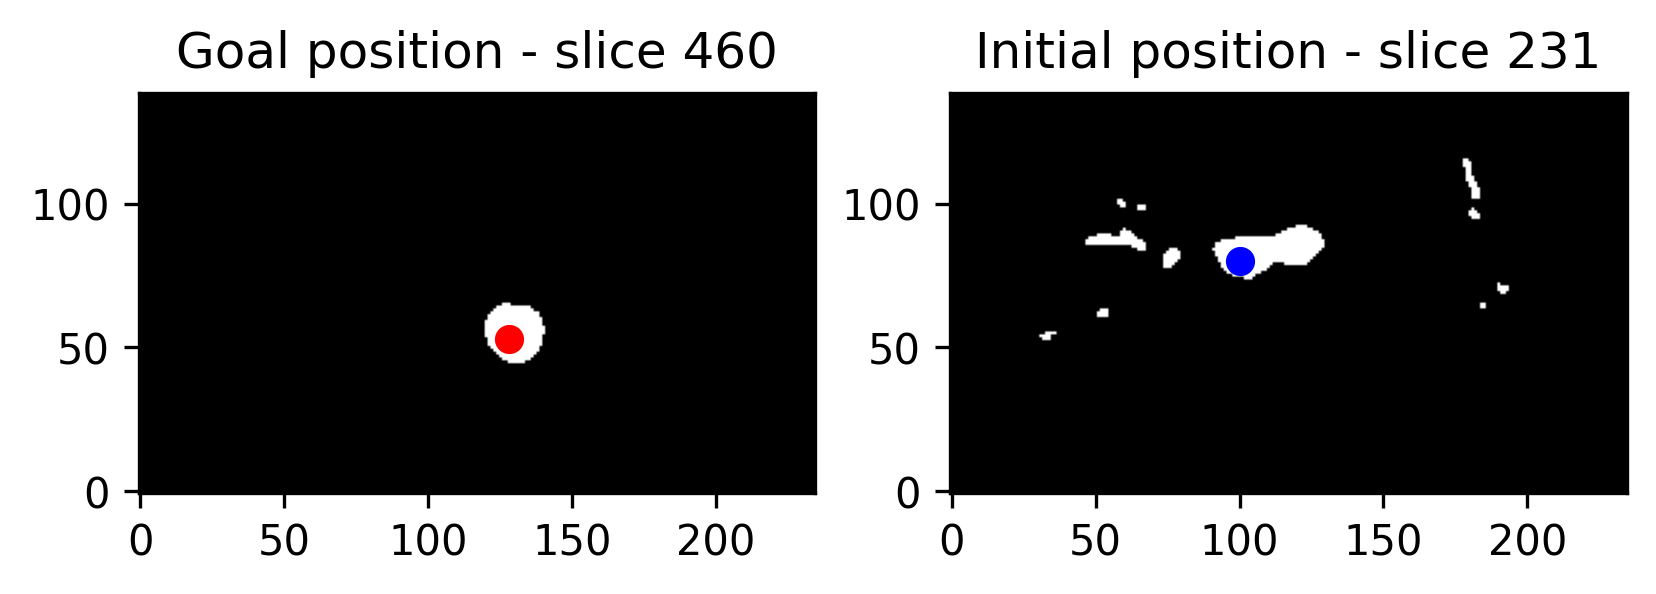

In [8]:
nb_slices = label.shape[0]
initial_position = (nb_slices // 2, 80, 100)
goal_position = (nb_slices-2, 53, 128)

fig, ax = plt.subplots(1, 2, dpi=300)
ax[0].imshow(label[nb_slices-2, :, :], cmap="gray", origin="lower")
ax[0].plot(128, 53, "ro")
ax[0].set(title=f"Goal position - slice {nb_slices-2}")
ax[1].imshow(label[nb_slices // 2, :, :], cmap="grey", origin="lower")
ax[1].plot(100, 80, "bo")
ax[1].set(title=f"Initial position - slice {nb_slices // 2}")
fig.show()

We can see from the a above exemple that the starting configuration is at position (231, 80, 100) and a condidate goal position is located at (460, 53, 128). This values will be used to define the boundary conditions in the laplacian matrix

# Absorbing boundary conditions mimicking concentration
In this setup, we are interested about modeling the following system at stationarity where $x_0$ is the position of the goal:

$$\begin{cases} 
\partial_t C = D\Delta C + C_0\delta_{x_0} \\
C(x, 0) = C_0\delta_{x_0} \space \forall x \in \Omega \\
C(x, t) = 0 \space \forall x \in \partial \Omega 
\end{cases}$$
 
If we consider the case $\partial_t C = 0$, the above system can be rewritten as :
$$\begin{cases} 
\Delta C = 0 \\
C(x_0) = \frac{C_0}{D} \delta_{x_0} \\
C(x) = 0 \space \forall x \in \partial \Omega 
\end{cases}$$

This gives an homogene function defined on a domain $\Omega$ with absorbing boundary conditions on $\partial \Omega$.

The main advantage of absorbing boundary conditions is that all terms corresponding to the boundary in the laplacian matrix can be removed and the right-hand side (rhs) of the system $Ax=b$ only contains zeros, excepted at the point $x_0$ where we can set a value we associate to $ \frac{C_0}{D}$. 

In [28]:
# Create the laplacian matrix
tic = time.perf_counter()
laplace_mat = create_laplacian_matrix_3d(*res, *steps)
# laplace_mat = splinalg.LaplacianNd(res, boundary_conditions='dirichlet').tosparse()
toc = time.perf_counter()
print(f"Laplacian matrix creation: {toc - tic:.2f} seconds")

# Select the index of the goal position
goal_index = sub2ind_3D(res, *goal_position)

laplace_mat[goal_index, :] = 0
laplace_mat[goal_index, goal_index] = 1

# Select index of the label mask
inside_boundary = label.flat > 0
# Restrict the laplacian matrix to the label mask
restricted_laplace_mat = laplace_mat[inside_boundary, :][:, inside_boundary]
restricted_laplace_mat.eliminate_zeros()

Laplacian matrix creation: 2.71 seconds


Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


Once the laplacian matrix is reduced by including absorbing boundary conditions, we just need to create the rhs of the system and call an efficient solver for the system $Ax = b$.

In [29]:
# We define a rhs of zeros everywhere except at the goal position
source = np.zeros_like(label, dtype=np.float64)
source[goal_position] = 1e3
b = source.flat[inside_boundary]
# We solve the linear system
tic = time.perf_counter()
x = splinalg.spsolve(restricted_laplace_mat, b)
tac = time.perf_counter()
print(f"Linear system solved in: {tac - tic:.2f} seconds")

# We reconstruct the solution
absorbing_bc_solution = np.zeros_like(label, dtype=np.float64)
absorbing_bc_solution.flat[inside_boundary] = x

Linear system solved in: 26.11 seconds


We can now visualize the solution with the help of the napari viewer.

In [30]:
viewer = napari.view_image(
    label, name="label", scale=steps, colormap="red"
)
viewer.add_image(
    absorbing_bc_solution, name="Absorbing BC", colormap="inferno", scale=steps, blending="additive"
)
napari.run()

# Emiting boundary conditions
As the previous solution deminish too quickly in space, one simple idea would be to replace absorbing boundary conditions with emiting boundary conditions, and modify the problem statement to expect a minum at the goal point. the system to solve would then be :

$$\begin{cases} 
\Delta f = 0 \\
f(x_0) = a \\
C(x) = b \space \forall x \in \partial \Omega 
\end{cases}$$

Where a and b are chosen such that the function is at a maximum on obstacles and minum at the goal position. For numerical simulation, we will use (a,b) = (0,1).

We now need to consider the frontiers of the domain in the laplacian matrix as boundary conditions are not zero anymore.

In [16]:
frontier: np.ndarray = ndi.binary_dilation(label, iterations=1) & ~label
frontier_index = frontier.flat > 0

# Designe the step size such that the volume lies in the range [0, 1]
new_steps = steps / res

tic = time.perf_counter()
laplace_mat = create_laplacian_matrix_3d(*res, *steps)
toc = time.perf_counter()
print(f"Laplacian matrix creation: {toc - tic:.2f} seconds")

Laplacian matrix creation: 4.05 seconds


In [17]:
import tqdm

def apply_dirichlet(A: sp.spmatrix, binary_map: np.ndarray, rhs: np.ndarray):
    """Apply the Dirichlet boundary conditions to the linear system.

    Args:
        A (sp.spmatrix): Sparse matrix of the linear system Ax = b
        binary_map (np.ndarray): binary map of the domain, where 1 correspond to spaces to apply the boundary conditions 
        rhs (np.ndarray): right-hand side of the linear system
        value (float, optional): Value of the Dirichlet boundary conditions. Defaults to 0.0.
    """
    res = binary_map.shape
    max_index = np.prod(res)
    assert A.shape == (max_index, max_index), "Shape mismatch between the matrix and the binary map"  

    rows, cols, slices = np.nonzero(binary_map)   
    for i, j, k in tqdm.tqdm(zip(rows, cols, slices), total=len(rows)):
        index = sub2ind_3D(res, i, j, k)
        
        A[index, index] = 1
        rhs[index] = binary_map[i, j, k]
        
        ind_o = sub2ind_3D(res, i + 1, j, k)
        ind_e = sub2ind_3D(res, i - 1, j, k)
        ind_n = sub2ind_3D(res, i, j + 1, k)
        ind_s = sub2ind_3D(res, i, j - 1, k)
        ind_u = sub2ind_3D(res, i, j, k + 1)
        ind_d = sub2ind_3D(res, i, j, k - 1)
        
        for neighbour_ind in [ind_o, ind_e, ind_n, ind_s, ind_u, ind_d]:
            # Set the row to the identity vector and apply the colums to rhs
            if neighbour_ind >= 0 and neighbour_ind < max_index:
                A[index, neighbour_ind] = 0
                rhs[neighbour_ind] -= A[neighbour_ind, index] * rhs[index]
                A[neighbour_ind, index] = 0
    return A, rhs        

Once again we need to add the boundary conditions on the right-hand side of the equation and then solve it.

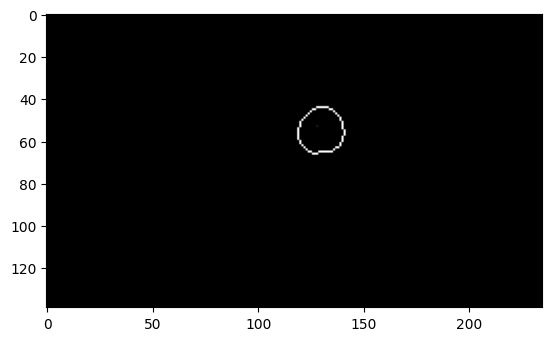

In [18]:
# Now we can define the proper coefficients for the laplacian matrix
rhs = np.zeros(laplace_mat.shape[0], dtype=np.float64)
goal_mask = np.zeros_like(label, dtype=float)
goal_mask[goal_position] = 1
binary_map = 10 * frontier + goal_mask

plt.imshow(binary_map[nb_slices - 2, :, :], cmap='grey')

100%|██████████| 68709/68709 [00:45<00:00, 1516.71it/s]


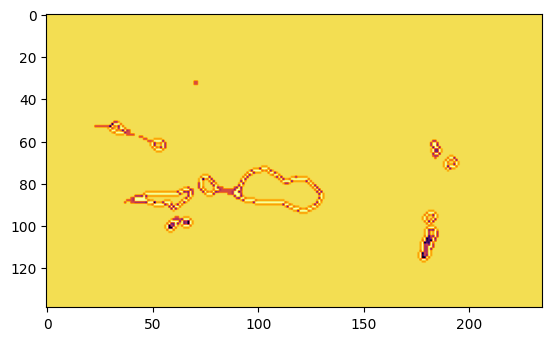

In [19]:
# We need to set the boundary condition for the goal
laplace_mat, rhs = apply_dirichlet(laplace_mat, binary_map, rhs)
plt.imshow(rhs.reshape(label.shape)[nb_slices // 2, :, :], cmap='inferno')

In [20]:
valid_idx = (label.flat > 0) | (frontier.flat > 0)
A = laplace_mat[valid_idx, :][:, valid_idx]
b = rhs[valid_idx]
# b = binary_map.flat[valid_idx]
sol = splinalg.spsolve(A, b)
solution = np.zeros_like(label, dtype=np.float64)
solution.flat[valid_idx] = sol

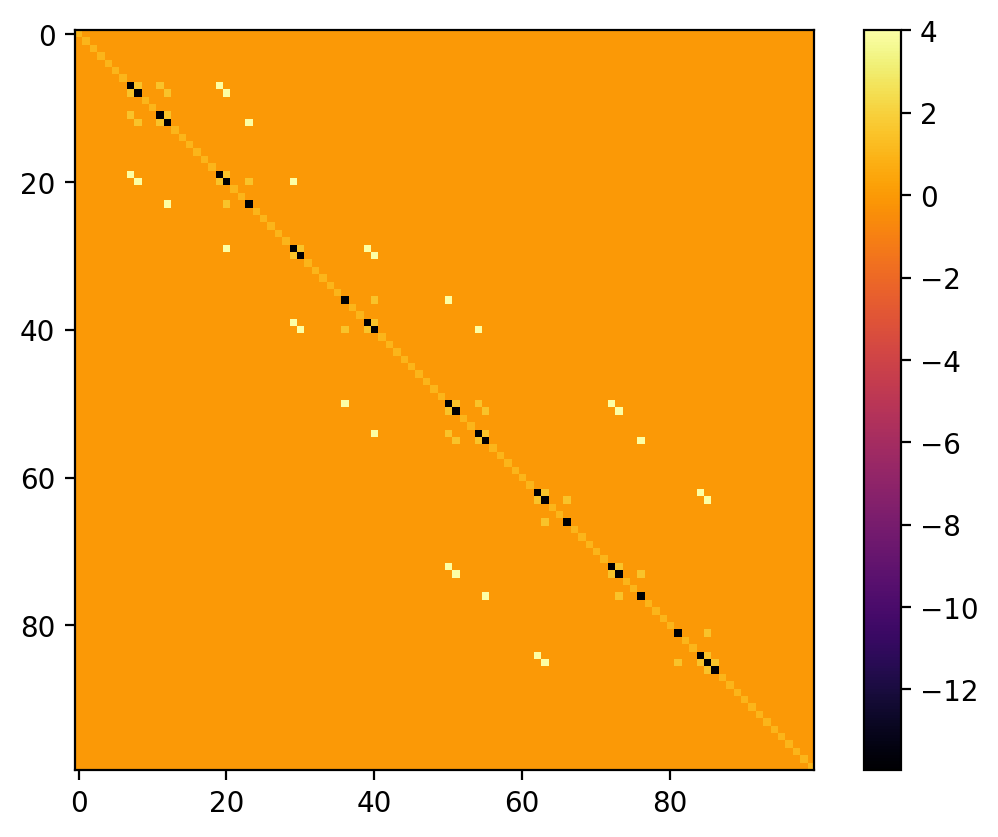

In [21]:
plt.figure(dpi=200)
plt.imshow(A[:100][:,:100].todense(), cmap='inferno')
plt.colorbar()

In [22]:
viewer = napari.view_image(
    label, name="label", scale=steps, colormap="red"
)
viewer.add_image(valid_idx.reshape(label.shape), name="valid_idx", scale=steps, colormap="gray")
viewer.add_image(rhs.reshape(label.shape), name="rhs", scale=steps, colormap="blue")
viewer.add_image(
    solution, name="Emitting BC", colormap="inferno", scale=steps, blending="additive"
)
napari.run()

# Introduction of boundary condition on the source

Laplacian matrix creation: 3.59 seconds


100%|██████████| 68710/68710 [00:48<00:00, 1427.03it/s]

Application of dirichlet BC : 48.23 seconds


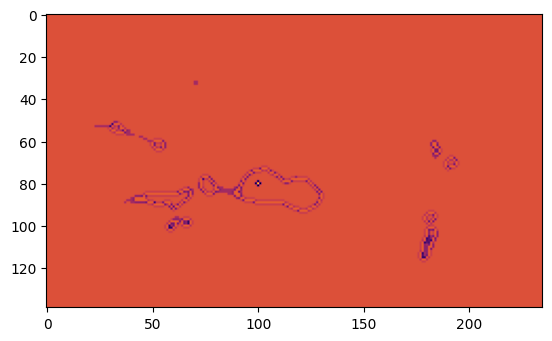

In [29]:
tic = time.perf_counter()
laplace_mat = create_laplacian_matrix_3d(*res, *steps)
toc = time.perf_counter()
print(f"Laplacian matrix creation: {toc - tic:.2f} seconds")
# Now we can define the proper coefficients for the laplacian matrix
rhs = np.zeros(laplace_mat.shape[0], dtype=np.float64)
goal_mask = np.zeros_like(label, dtype=float)
goal_mask[goal_position] = 1
goal_mask[initial_position] = 100
binary_map = 10 * frontier + goal_mask

# We need to set the boundary condition for the goal
tic = time.perf_counter()
laplace_mat, rhs = apply_dirichlet(laplace_mat, binary_map, rhs)
toc = time.perf_counter()
print(f"Application of dirichlet BC : {toc - tic:.2f} seconds")
plt.imshow(rhs.reshape(label.shape)[nb_slices // 2, :, :], cmap='inferno')

In [30]:
A = laplace_mat[valid_idx, :][:, valid_idx]
b = rhs[valid_idx]
# b = binary_map.flat[valid_idx]
sol = splinalg.spsolve(A, b)
solution = np.zeros_like(label, dtype=np.float64)
solution.flat[valid_idx] = sol

In [31]:
viewer = napari.view_image(
    label, name="label", scale=steps, colormap="red"
)
# viewer.add_image(valid_idx.reshape(label.shape), name="valid_idx", scale=steps, colormap="gray")
viewer.add_image(rhs.reshape(label.shape), name="rhs", scale=steps, colormap="blue")
viewer.add_image(
    solution, name="Emitting BC", colormap="inferno", scale=steps, blending="additive"
)
napari.run()

# Basic tests of taichi mesh structure

In [ ]:
import taichi as ti
import taichi.math as tm

ti.init(arch=ti.gpu)
ti.Mesh()